# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells already run. You will also need to write a short, 2 page report about your design decisions as a team, to be uploaded to Moodle in the form of a PDF file next to this Jupyter notebook.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

DATA_DIR = './data' # You many change the directory

# Your code goes here

## Task 0: Research Question

**Research question:**

*Predict users performance based on their activity behaviour*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

In [2]:
# Your code for data processing goes here

### Here call your scripts for preprocessing, also explain the preprocessing steps that you did in general + data loss + graphs 

activity = pd.read_csv('{}/features/activity.csv'.format(DATA_DIR))
performances = pd.read_csv('{}/features/performances.csv'.format(DATA_DIR))

**Comment:** Unfortunately, many of the activity data points are not useable as our main method relies on looking at the behaviour of the students and therefore the time spent on activities is important to us. In the following graph we can see the ammount of activity data that is of length 0.

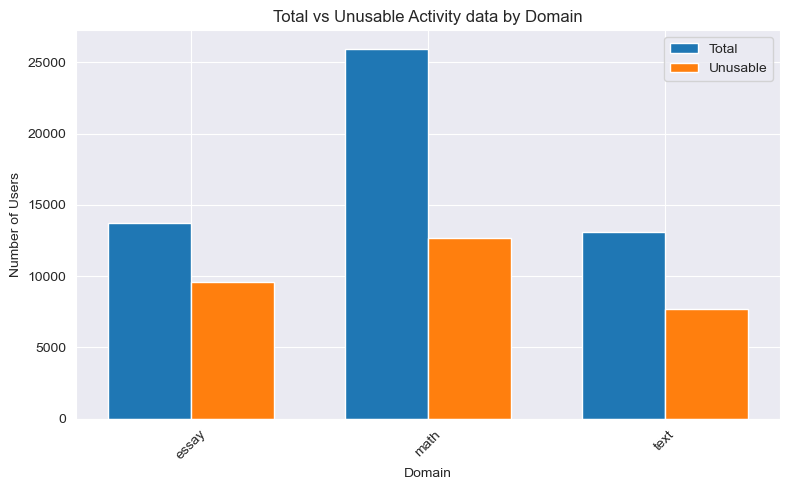

In [3]:
total = activity.groupby('domain')['user_id'].count()
unuseable = activity[activity['activity_completed'].isna()]
unuseable_count = unuseable.groupby('domain')['user_id'].count()

domains = sorted(set(total.index).union(set(unuseable_count.index)))
total = total.reindex(domains, fill_value=0)
unuseable_count = unuseable_count.reindex(domains, fill_value=0)

x = np.arange(len(domains))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, total, width, label='Total')
plt.bar(x + width/2, unuseable_count, width, label='Unusable')

plt.ylabel('Number of Users')
plt.xlabel('Domain')
plt.title('Total vs Unusable Activity data by Domain')
plt.xticks(x, domains, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
print(f'By deleting these colums, we lose {(unuseable_count.sum()/total.sum() * 100).round(2)} % of the initial data ...')

By deleting these colums, we lose 56.67 % of the initial data ...


In [5]:
activity.dropna(inplace=True)

**Comment:** This is quite a big loss of data but a necessary one... (see annexe for trial without this loss of data)

### Feature engineering 

**Our aim is to predict a user's score on their first attempt at a specific exam, based on their behavior leading up to it. To train our model, we engineered the following features to capture and characterize user behavior:**

- recent_avg_time_per_activity

*The average time (in minutes) spent per activity during the last 10 days before the exam, including the exam day. This reflects how intensely the user has been engaging recently.*

- days_since_last_activity

*The number of days between the user's most recent activity and the exam. A higher value indicates a longer gap in studying before the exam.*

- total_time_spent_on_activity_before_exam

*The total amount of time (in minutes) the user spent on activities prior to the exam. This gives a sense of overall study investment leading up to the test.*

- average_performance_past_exams

*The mean performance from the user's previous exams (before this one). This can provide a rough estimate of the user's historical performance.*

- avg_activities_per_day_recent

*The average number of activities completed per day in the last 10-days window. A higher number suggests more consistent or intense preparation.*

- active_days_ratio_recent

*The proportion of days (out of the last 10) on which the user was active. This indicates how regularly they studied leading up to the exam.*

- diversity_recent

*The number of unique activity types completed in the rolling window. Higher diversity could reflect more varied engagement with different learning methods or content types.*


In [6]:
# Rolling window for recent activity
rolling_window_days = 10


def compute_all_features_for_exam(exam_row, user_activities, user_exams, window_days=rolling_window_days):

    exam_dt = exam_row['time']


    # Include activities up to and including exam_date
    previous_activities = user_activities[user_activities['activity_updated'] < exam_dt].copy()


    # Rolling window (activities in the last N days, including exam day)
    window_start = exam_dt - pd.Timedelta(days=window_days)
    rolling_activities = previous_activities[previous_activities['activity_updated'] >= window_start].copy()

    features = {}


    # Recent average time per activity (rolling window)
    total_time_rolling = rolling_activities['time_in_minutes'].sum()
    count_rolling = len(rolling_activities)
    features['recent_avg_time_per_activity'] = total_time_rolling / count_rolling if count_rolling > 0 else 0


    # Number of days since last activity
    if not previous_activities.empty:
        last_activity_date = previous_activities['activity_updated'].max()
        features['days_since_last_activity'] = (exam_dt - last_activity_date).days
    else:
        features['days_since_last_activity'] = np.nan


    # Total time spent on activities before the exam
    features['total_time_spent_on_activity_before_exam'] = previous_activities['time_in_minutes'].sum() if not previous_activities.empty else 0


    # Average performance on past exams
    previous_exams = user_exams[user_exams['time'] < exam_dt]
    features['average_performance_past_exams'] = previous_exams['performance'].mean() if not previous_exams.empty else np.nan


    # Usage Frequency: Average activities per day in rolling window & Active days ratio
    features['avg_activities_per_day_recent'] = count_rolling / window_days if window_days > 0 else np.nan
    if not rolling_activities.empty:
        distinct_days = rolling_activities['activity_updated'].dt.normalize().nunique()
    else:
        distinct_days = 0
    features['active_days_ratio_recent'] = distinct_days / window_days if window_days > 0 else np.nan


    # Activity diversity (rolling window)
    features['diversity_recent'] = rolling_activities['activity_type'].nunique() if not rolling_activities.empty else 0


    return pd.Series(features)


**All features are calculated separately within each domain — Math, Text, and Essay — to capture domain-specific learning patterns and engagement.**

We have also scaled the features using a standard because we assume a normal distribution

In [7]:
scaler = StandardScaler()
columns_to_scale = ['recent_avg_time_per_activity', 'days_since_last_activity', 'total_time_spent_on_activity_before_exam','average_performance_past_exams','avg_activities_per_day_recent','diversity_recent']

#### Math data 

In [8]:
performances_math = performances[performances['domain']== 'math'].copy()
activity_math = activity[activity['domain']== 'math'].copy()

# Convert the 'date' columns to datetime
activity_math['activity_updated'] = pd.to_datetime(activity_math['activity_updated'])
performances_math['time'] = pd.to_datetime(performances_math['time'])

# Loop over each exam (grouped by user) in performances_math and compute all features.
features_list = []

for user_id, user_exams in performances_math.groupby('user_id'):
    # Get corresponding activities for the user from activity_math and sort by date
    user_activities = activity_math[activity_math['user_id'] == user_id].sort_values('activity_updated')
    user_exams_sorted = user_exams.sort_values('time')

    for exam_index, exam_row in user_exams_sorted.iterrows():
        feats = compute_all_features_for_exam(exam_row, user_activities, user_exams_sorted, rolling_window_days)
        feats['exam_index'] = exam_index
        features_list.append(feats)

# Output df
features_df = pd.DataFrame(features_list).set_index('exam_index')
performances_math_features = performances_math.join(features_df, how='left')


# scaling the columns
scaled_values = scaler.fit_transform(performances_math_features[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performances_math_features.index)
remaining_df = performances_math_features.drop(columns=columns_to_scale)
final_df_math = pd.concat([scaled_df, remaining_df], axis=1)

In [9]:
final_df_math.isnull().sum()

recent_avg_time_per_activity                  0
days_since_last_activity                     56
total_time_spent_on_activity_before_exam      0
average_performance_past_exams              469
avg_activities_per_day_recent                 0
diversity_recent                              0
user_id                                       0
domain                                        0
test_id                                       0
course                                        0
date                                          0
time                                          0
percentage                                    0
performance                                   0
active_days_ratio_recent                      0
dtype: int64

In [10]:
print('Total Nb of rows :', final_df_math.user_id.count())
print('Nb of rows where we are missing feature values :', final_df_math.isna().any(axis=1).sum())
print('Percentage of rows where we are missing feature values :', final_df_math.isna().any(axis=1).sum()/ final_df_math.user_id.count() * 100)

Total Nb of rows : 3810
Nb of rows where we are missing feature values : 470
Percentage of rows where we are missing feature values : 12.335958005249344


**Comment:** Some features for certain rows cannot be computed, particularly the "average_performance_past_exams" feature. This occurs for the first exam questions attempted by each user, where no prior performance data is available.

**Comment:** For the math dataset, approximately 12% of the data is affected by this issue. However, if we were to remove this data the loss is minor and there are still around 3400 healthy data points that remain.

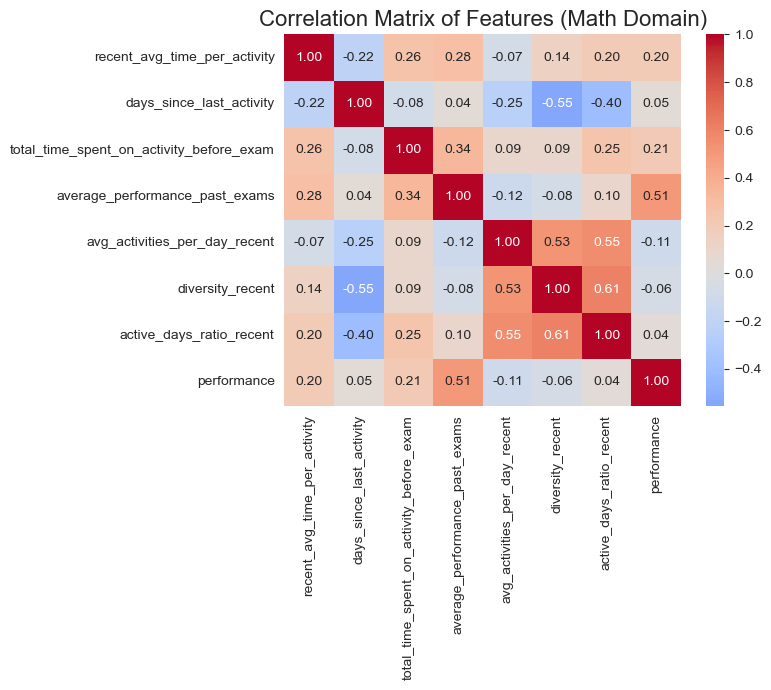

In [11]:
feature_columns = [
    'recent_avg_time_per_activity',
    'days_since_last_activity',
    'total_time_spent_on_activity_before_exam',
    'average_performance_past_exams',
    'avg_activities_per_day_recent',
    'diversity_recent',
    'active_days_ratio_recent',
    'performance'  
]

correlation_matrix_math = final_df_math[feature_columns].corr()

plt.figure(figsize=(8, 7))
sns.heatmap(correlation_matrix_math, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Features (Math Domain)", fontsize=16)
plt.tight_layout()
plt.show()

#### Essay data

In [12]:
performances_essay = performances[performances['domain']== 'essay'].copy()
activity_essay= activity[activity['domain']== 'essay'].copy()

# Convert the date columns  to datetime
activity_essay['activity_updated'] = pd.to_datetime(activity_essay['activity_updated'])
performances_essay['time'] = pd.to_datetime(performances_essay['time'])

# Loop over each exam (grouped by user) in performances_essay and compute all features.
features_list = []

for user_id, user_exams in performances_essay.groupby('user_id'):
    # Get corresponding activities for the user from activity_essay and sort by date
    user_activities = activity_essay[activity_essay['user_id'] == user_id].sort_values('date')
    user_exams_sorted = user_exams.sort_values('date')

    for exam_index, exam_row in user_exams_sorted.iterrows():
        feats = compute_all_features_for_exam(exam_row, user_activities, user_exams_sorted, rolling_window_days)
        feats['exam_index'] = exam_index
        features_list.append(feats)

# Output df
features_df = pd.DataFrame(features_list).set_index('exam_index')
performances_essay_features = performances_essay.join(features_df, how='left')


# scaling the columns
scaled_values = scaler.fit_transform(performances_essay_features[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performances_essay_features.index)
remaining_df = performances_essay_features.drop(columns=columns_to_scale)
final_df_essay = pd.concat([scaled_df, remaining_df], axis=1)

In [13]:
final_df_essay.isnull().sum()

recent_avg_time_per_activity                  0
days_since_last_activity                    193
total_time_spent_on_activity_before_exam      0
average_performance_past_exams              308
avg_activities_per_day_recent                 0
diversity_recent                              0
user_id                                       0
domain                                        0
test_id                                       0
course                                        0
date                                          0
time                                          0
percentage                                    0
performance                                   0
active_days_ratio_recent                      0
dtype: int64

In [14]:
print('Total Nb of rows :', final_df_essay.user_id.count())
print('Nb of rows where we are missing feature values :', final_df_essay.isna().any(axis=1).sum())
print('Percentage of rows where we are missing feature values :', final_df_essay.isna().any(axis=1).sum()/ final_df_essay.user_id.count() * 100)

Total Nb of rows : 581
Nb of rows where we are missing feature values : 361
Percentage of rows where we are missing feature values : 62.1342512908778


**Comment:** The essay domain has very limited data available, with only 581 rows usable for training. 

**Comment:** Many rows are also missing the "average_performance_past_exams" feature. These are missing for the same reason as previously mentionned. Due to the already limited amount of data, this will prove to be problematic.

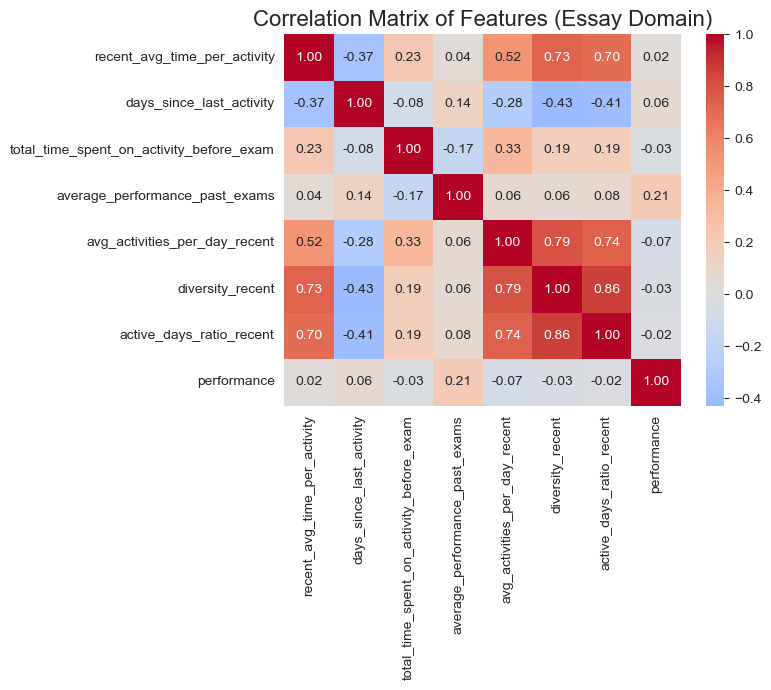

In [15]:
correlation_matrix_essay = final_df_essay[feature_columns].corr()

plt.figure(figsize=(8, 7))
sns.heatmap(correlation_matrix_essay, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Features (Essay Domain)", fontsize=16)
plt.tight_layout()
plt.show()

#### Text data 

In [16]:
performances_text = performances[performances['domain']== 'text'].copy()
activity_text= activity[activity['domain']== 'text'].copy()

# Convert the date columns to datetime
activity_text['activity_updated'] = pd.to_datetime(activity_text['activity_updated'])
performances_text['time'] = pd.to_datetime(performances_text['time'])

# Loop over each exam (grouped by user) in performances_text and compute all features.
features_list = []

for user_id, user_exams in performances_text.groupby('user_id'):
    # Get corresponding activities for the user from activity_text and sort by date
    user_activities = activity_text[activity_text['user_id'] == user_id].sort_values('date')
    user_exams_sorted = user_exams.sort_values('date')

    for exam_index, exam_row in user_exams_sorted.iterrows():
        feats = compute_all_features_for_exam(exam_row, user_activities, user_exams_sorted, rolling_window_days)
        feats['exam_index'] = exam_index
        features_list.append(feats)

# Output df
features_df = pd.DataFrame(features_list).set_index('exam_index')
performances_text_features = performances_text.join(features_df, how='left')


# Scale the columns
scaled_values = scaler.fit_transform(performances_text_features[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performances_text_features.index)
remaining_df = performances_text_features.drop(columns=columns_to_scale)
final_df_text = pd.concat([scaled_df, remaining_df], axis=1)

In [17]:
final_df_text.isnull().sum()

recent_avg_time_per_activity                  0
days_since_last_activity                    307
total_time_spent_on_activity_before_exam      0
average_performance_past_exams              122
avg_activities_per_day_recent                 0
diversity_recent                              0
user_id                                       0
domain                                        0
test_id                                       0
course                                        0
date                                          0
time                                          0
percentage                                    0
performance                                   0
active_days_ratio_recent                      0
dtype: int64

In [18]:
print('Total Nb of rows :', final_df_text.user_id.count())
print('Nb of rows where we are missing feature values :', final_df_text.isna().any(axis=1).sum())
print('Percentage of rows where we are missing feature values :', final_df_text.isna().any(axis=1).sum()/ final_df_text.user_id.count() * 100)

Total Nb of rows : 445
Nb of rows where we are missing feature values : 356
Percentage of rows where we are missing feature values : 80.0


**Comment:** The text domain has even less data available, with only 445 rows usable for training. 

**Comment:** Approximately 80% of the rows are missing with most coming from "days_since_last_activity". This means that users took the exam with no prior activity logs, meaning that, for our research question, these rows are useless since we are trying to predict performance based on past activity. There are also many rows where the "average_performance_past_exams" feature is missing, which will prove problematic.

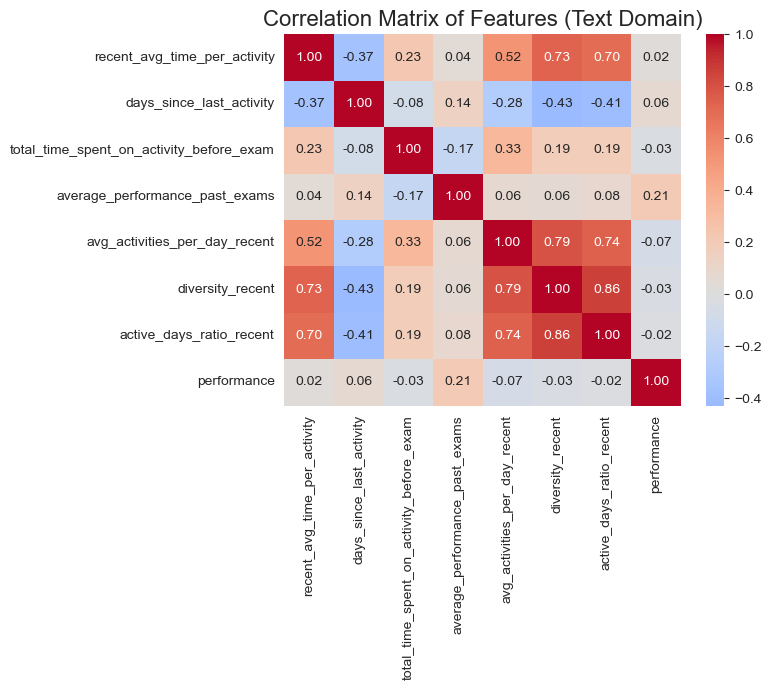

In [19]:
correlation_matrix_text = final_df_essay[feature_columns].corr()

plt.figure(figsize=(8, 7))
sns.heatmap(correlation_matrix_text, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Features (Text Domain)", fontsize=16)
plt.tight_layout()
plt.show()

*Your discussion about your processing decisions goes here*


When looking at the correlation analysis, we observe that the feature most strongly correlated with performance is "average_performance_past_exams." This presents a significant problem for the essay and text datasets, where not only are there very few rows to begin with, but this important feature is often missing. As a result, we decided to focus our efforts on the math data, where we have a much healthier number of data points available.

We did attempt to train models on the essay and text data; however, the performance was very poor, likely due to the limited amount of training examples and the missing key features. Training a model with so little data is highly unreliable and unlikely to generalize well. On the other hand, if our approach works well on the math data, it suggests that the methodology could be transferable to other domains, provided enough data points are available to fit a model properly.

## Task 2: Model Building

Train a model for your research question. 

**Comment:** Seeing the lack of data available to us for both the text and essay domains, we decided to concentrate on the math data for the following parts. We also tried out multiple models to try and see if we could improve performance at all. Therefore all following models are solely for the math data.

### Method 0 : Simple Linear Regression where we drop NAN

Sometimes, the simplest approaches can be the most effective. For our baseline model, we began by dropping any rows containing missing values (NaNs) to ensure a clean dataset. We then applied a simple linear regression model to predict exam performance based on the available features. This served as a straightforward benchmark to compare against more complex models.

In [20]:
final_df_math_drop = final_df_math.copy()
final_df_math_drop.dropna(inplace=True)


# Linear Regression Model
mod_method0 = smf.ols(formula='performance ~  recent_avg_time_per_activity + days_since_last_activity + total_time_spent_on_activity_before_exam + average_performance_past_exams + avg_activities_per_day_recent + diversity_recent', data=final_df_math_drop)
# Fit the model
res_method0 = mod_method0.fit()

# Print regression results summary 
#print(res_method0.summary())

### Method 1 : Mixed Effects Linear Regression where we drop NAN and cluster the users 

To enhance our simple linear regression model, we employed a K-Means clustering approach to group users based on their feature profiles. This allowed us to account for heterogeneity among users by capturing patterns in behavior and performance. By incorporating these clusters as mixed effects, we aimed to improve the model’s ability to generalize across diverse user groups and better explain variations in exam outcomes.

In [21]:
# Collapse to one row per user for clustering
user_feats = final_df_math_drop.groupby('user_id')[['recent_avg_time_per_activity', 'days_since_last_activity', 'total_time_spent_on_activity_before_exam', 'average_performance_past_exams', 'avg_activities_per_day_recent', 'active_days_ratio_recent', 'diversity_recent']].mean().reset_index()

# Cluster into 3 groups
kmeans = KMeans(n_clusters=3, random_state=0)
user_feats['cluster'] = kmeans.fit_predict(user_feats.drop(columns='user_id'))

# Merge cluster label back into final_df
df2 = final_df_math_drop.merge(user_feats[['user_id','cluster']], on='user_id')

# Fit a mixed‐effects model with random intercept per cluster
mod_method1 = smf.mixedlm("performance ~ recent_avg_time_per_activity + days_since_last_activity + total_time_spent_on_activity_before_exam + average_performance_past_exams + avg_activities_per_day_recent + active_days_ratio_recent + diversity_recent",df2,groups="cluster")
res_method1 = mod_method1.fit(reml=False)

# In-sample predictions
df2["pred_cluster"] = res_method1.predict(df2)

# Compute R² and RMSE
# r2_cluster = r2_score(df2["performance"], df2["pred_cluster"])
# rmse_cluster = mean_squared_error(df2["performance"], df2["pred_cluster"])

# print("Cluster‐model  AIC:",  mdf.aic, "  BIC:", mdf.bic)
# print(f"Cluster‐model  R² = {r2_cluster:.3f},  RMSE = {rmse_cluster:.3f}")

### Method 2 : Simple Linear Regression where we impute the missing NAN values with the median value for that exam


For this method we used a simple linear regression model with median imputation for missing values. Specifically, any NaN values were filled with the median value for the corresponding feature within each exam. This approach preserved more data compared to dropping rows and allowed the model to leverage a broader training set while maintaining simplicity.

In [22]:
performance_math_median = performances_math_features.copy()

# Fill by test_id median
performance_math_median['average_performance_past_exams'] = (
    performance_math_median
    .groupby('test_id')['average_performance_past_exams']
    .transform(lambda x: x.fillna(x.median()))
    .fillna(performance_math_median['average_performance_past_exams'].median())   # fallback to global median if a test has no median
)

# scaling the columns
columns_to_scale = ['recent_avg_time_per_activity', 'days_since_last_activity', 'total_time_spent_on_activity_before_exam','average_performance_past_exams','avg_activities_per_day_recent','active_days_ratio_recent','diversity_recent']


scaler = StandardScaler()
scaled_values = scaler.fit_transform(performance_math_median[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performance_math_median.index)
remaining_df = performance_math_median.drop(columns=columns_to_scale)
final_df_med = pd.concat([scaled_df, remaining_df], axis=1)

In [23]:
# Linear Regression Model
mod_method2 = smf.ols(formula= 'performance ~  recent_avg_time_per_activity + days_since_last_activity + total_time_spent_on_activity_before_exam + average_performance_past_exams + avg_activities_per_day_recent + active_days_ratio_recent + diversity_recent', data=final_df_med)

# Fit the model
res_method2 = mod_method2.fit()

# Print regression results summary
#print(res_method2.summary())

### Method 3 : Simple Linear Regression where we impute the missing NAN values using KNN

For Method 3, we applied a simple linear regression model with K-Nearest Neighbors (KNN) imputation for missing values. Instead of using global statistics like the median, KNN imputation estimates missing values based on the most similar observations in the dataset. This method allows for more context-aware imputations, potentially preserving underlying data relationships and improving the model’s predictive performance.

In [24]:
performance_math_impute = performances_math_features.copy()

# Features we’ll use to compute similarity:
sim_features = ['recent_avg_time_per_activity','days_since_last_activity','total_time_spent_on_activity_before_exam',
                'avg_activities_per_day_recent','active_days_ratio_recent','diversity_recent']

# New column to hold the imputed values
performance_math_impute['avg_perf_past_exams_imputed'] = performance_math_impute['average_performance_past_exams']

# Group by test_id and run kNN inside each group
for test_id, group in performance_math_impute.groupby('test_id'):
    # indices of rows we need to fill
    missing_idx = group[group['average_performance_past_exams'].isna()].index
    if len(missing_idx) == 0:
        continue

    # candidate neighbors: same test, non‐missing avg_pct
    candidates = group[group['average_performance_past_exams'].notna()]
    if candidates.shape[0] == 0:
        # if no one else took that test --> impute median
        continue

    # Matrix of sim_features, impute median for remaining NaNs
    feat_mat = group[sim_features].copy()
    feat_mat = feat_mat.fillna(feat_mat.median())

    # Split into X_train (candidates) and X_query (the missing rows)
    X_train = feat_mat.loc[candidates.index].values
    X_query = feat_mat.loc[missing_idx].values

    # Use up to 3 neighbors (fewer if not enough candidates)
    k = min(3, X_train.shape[0])
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X_train)
    distances, neighbors = nbrs.kneighbors(X_query)

    # For each missing row, average the actual test scores of its neighbors
    candidate_scores = candidates['performance'].values
    for i, idx in enumerate(missing_idx):
        nbr_idxs = neighbors[i]
        imputed_val = candidate_scores[nbr_idxs].mean()
        performance_math_impute.at[idx, 'avg_perf_past_exams_imputed'] = imputed_val

# Replace the original column
performance_math_impute['average_performance_past_exams'] = performance_math_impute['avg_perf_past_exams_imputed']
performance_math_impute.drop(columns='avg_perf_past_exams_imputed', inplace=True)

In [25]:
# scaling the columns
columns_to_scale = ['recent_avg_time_per_activity', 'days_since_last_activity', 'total_time_spent_on_activity_before_exam','average_performance_past_exams','avg_activities_per_day_recent','active_days_ratio_recent','diversity_recent']
scaler = StandardScaler()
scaled_values = scaler.fit_transform(performance_math_impute[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performance_math_impute.index)
remaining_df = performance_math_impute.drop(columns=columns_to_scale)
final_df_impute = pd.concat([scaled_df, remaining_df], axis=1)

In [26]:
final_df_impute.dropna(inplace=True) # drop the remaining NaNs

# Linear Regression Model
mod_method3 = smf.ols(formula= 'performance ~  recent_avg_time_per_activity + days_since_last_activity + total_time_spent_on_activity_before_exam + average_performance_past_exams + avg_activities_per_day_recent + active_days_ratio_recent + diversity_recent', data=final_df_impute)

# Fit the model
res_method3 = mod_method3.fit()

# Print regression results summary
#print(res_method3.summary())

### Method 4 : Gradient Boosting Regressor that accepts NAN values 

For Method 4, we used a Gradient Boosting Regressor that natively handles missing values. Unlike simpler models, gradient boosting can internally learn how to deal with NaNs during training by simply sending them “one way or the other” at each split, making it well-suited for real-world, imperfect data. This approach allowed us to retain the full dataset without requiring explicit imputation, while benefiting from the model's ability to capture complex, non-linear relationships in the features.


In [28]:
df = performances_math_features.copy()

feature_cols = ['recent_avg_time_per_activity','days_since_last_activity','total_time_spent_on_activity_before_exam','average_performance_past_exams',
    'avg_activities_per_day_recent','active_days_ratio_recent','diversity_recent']

X = df[feature_cols]
y = df['performance']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline: impute → scale → gradient boost
pipeline = Pipeline([
    ('scaler',    StandardScaler()),
    ('hgb',    HistGradientBoostingRegressor(random_state=42))
])

# Grid search for key hyperparameters
param_grid = {'hgb__learning_rate': [0.05, 0.1], 'hgb__max_iter':      [100, 200], 'hgb__max_depth':     [3, 5], 'hgb__min_samples_leaf': [20, 50]}
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Fit the model
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

# Evaluate on the test set
y_pred = best_model.predict(X_test)
# print("Test R²:", r2_score(y_test, y_pred))
# print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Cross‑validated performance
# cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2', n_jobs=-1)
# print("5‑fold CV R²: %0.3f ± %0.3f" % (cv_scores.mean(), cv_scores.std()))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'hgb__learning_rate': 0.05, 'hgb__max_depth': 3, 'hgb__max_iter': 100, 'hgb__min_samples_leaf': 50}


*Your discussion about your model training goes here*

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

### Model 0 : 

Simple Linear Regression where we drop NAN

In [28]:
# Print regression results summary
print(res_method0.summary())


final_df_math_drop['predicted_performance'] = res_method0.fittedvalues
rmse_method0 = mean_squared_error(final_df_math_drop["performance"], final_df_math_drop['predicted_performance'])
print('RMSE :', rmse_method0)

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     202.1
Date:                Tue, 29 Apr 2025   Prob (F-statistic):          2.41e-220
Time:                        15:21:27   Log-Likelihood:                -15422.
No. Observations:                3340   AIC:                         3.086e+04
Df Residuals:                    3333   BIC:                         3.090e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

**Comment:** The simple linear regression model where we drop the NAN's has an R-squared of 0.267, meaning it explains 26.7% of the variance in performance. While this is a relatively modest value, it's actually quite good for real world data, which tends to be noisy and influenced by factors not captured in the model. The significant predictors, such as "recent_average_time_per_activity" and "total_time_spent_on_activity_before_exam" suggest the model is capturing meaningful patterns. The "average_performance_in_past_exams" feature is also significant and has the largest coefficient. This reinforces our decision to focus on the math data, as this feature is less available in the essay and text domain data.

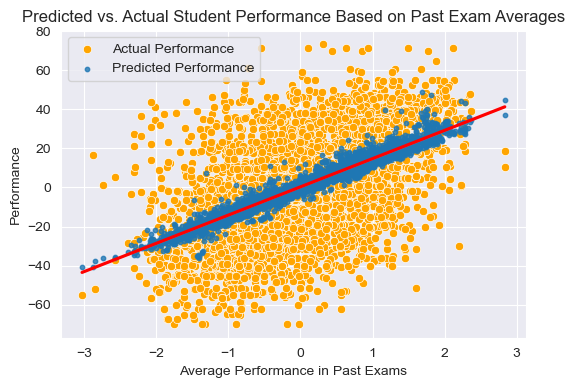

In [29]:
##### Not convinced about this plot -----> keep it or not ?


final_df_math_drop['predicted_performance'] = res_method0.fittedvalues

plt.figure(figsize=(6, 4))

sns.scatterplot(x='average_performance_past_exams', y='performance', data=final_df_math_drop, color='orange', label='Actual Performance')
sns.regplot(x='average_performance_past_exams', y='predicted_performance', data=final_df_math_drop, scatter_kws={'s': 10}, line_kws={'color': 'red'}, label='Predicted Performance')

plt.xlabel('Average Performance in Past Exams')
plt.ylabel('Performance')
plt.title('Predicted vs. Actual Student Performance Based on Past Exam Averages')
plt.legend()
plt.show()

**Comment:** The plot illustrates the relationship between the "average_performance_in_past_exams" and the model’s predicted performance. This feature showed the strongest correlation with actual performance in the preliminary analysis and also emerged as the most significant predictor in our model, with the largest coefficient. Visualizing its impact helps us understand how well the model captures this relationship. As seen in the plot, there is a clear upward trend in the actual performance data, and the model has effectively captured this pattern in its predictions.

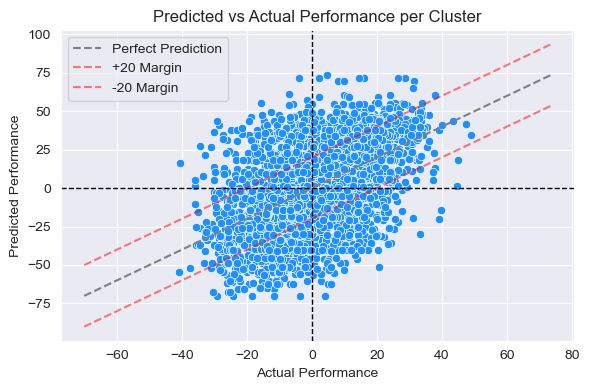

In [30]:
plt.figure(figsize=(6, 4))

sns.scatterplot(x='predicted_performance', y='performance', data=final_df_math_drop, color='dodgerblue')

min_val = min(final_df_math_drop['performance'].min(), final_df_math_drop['predicted_performance'].min())
max_val = max(final_df_math_drop['performance'].max(), final_df_math_drop['predicted_performance'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color="gray", label='Perfect Prediction')

buffer = 20
plt.plot([min_val, max_val], [min_val + buffer, max_val + buffer], ls="--", color="red", alpha=0.5, label=f'+{buffer} Margin')
plt.plot([min_val, max_val], [min_val - buffer, max_val - buffer], ls="--", color="red", alpha=0.5, label=f'-{buffer} Margin')

mean_actual = 0
mean_pred = 0

plt.axhline(mean_actual, color="black", linestyle="--", linewidth=1)
plt.axvline(mean_pred, color="black", linestyle="--", linewidth=1)

plt.xlabel('Actual Performance')
plt.ylabel('Predicted Performance')
plt.title("Predicted vs Actual Performance per Cluster")
plt.legend()
plt.tight_layout()
plt.show()

**Comment:** By examining the model’s predictions against the actual performance values, we gain a better sense of its precision. The model captures the overall trend in performance reasonably well, though there is still a noticeable amount of error — which is to be expected given the complexity and variability of the data.

That said, there are encouraging signs. The black dashed lines divide the plot into four quadrants that reflect the directional accuracy of the model’s predictions. A well-performing model should have most points in the top-right (both predicted and actual are high) and bottom-left (both predicted and actual are low) quadrants. In this case, the majority of points do fall into these two quadrants, suggesting that the model generally gets the direction of performance correct, even if it doesn’t always predict the exact value.


In [31]:
conditions_model0 = [
    (final_df_math_drop["predicted_performance"] >= mean_pred) & (final_df_math_drop["performance"] >= mean_actual),  # TP
    (final_df_math_drop["predicted_performance"] < mean_pred) & (final_df_math_drop["performance"] < mean_actual),    # TN
    (final_df_math_drop["predicted_performance"] >= mean_pred) & (final_df_math_drop["performance"] < mean_actual),   # FP
    (final_df_math_drop["predicted_performance"] < mean_pred) & (final_df_math_drop["performance"] >= mean_actual),   # FN
]

choices = ['TP', 'TN', 'FP', 'FN']
final_df_math_drop['quadrant'] = np.select(conditions_model0, choices, default='Other')

counts_model0 = final_df_math_drop['quadrant'].value_counts()

print("Quadrant Classification Counts:")
print(counts_model0)

tp = counts_model0.get('TP', 0)
tn = counts_model0.get('TN', 0)
fp = counts_model0.get('FP', 0)
fn = counts_model0.get('FN', 0)

directional_accuracy_model0 = (tp + tn) / (tp + tn + fp + fn)
print(f"\nDirectional Accuracy: {directional_accuracy_model0:.4f}")

Quadrant Classification Counts:
quadrant
TP    1178
TN    1170
FN     523
FP     469
Name: count, dtype: int64

Directional Accuracy: 0.7030


**Comment:** The directional accuracy of our model is 0.7030, meaning it correctly predicts whether a student’s performance will be above or below zero in 70% of cases. This indicates that the model is successfully learning meaningful patterns in user behavior that help it distinguish between generally good and poor performance. While it’s not perfect, this level of directional accuracy is an encouraging sign!!!

### Model 1 :

Mixed Effects Linear Regression where we drop NAN and cluster the users 

In [32]:
print(res_method1.summary())

# Compute R² and RMSE
r2_cluster = r2_score(df2["performance"], df2["pred_cluster"])
rmse_cluster = mean_squared_error(df2["performance"], df2["pred_cluster"])

print("Cluster‐model  AIC:",  res_method1.aic, "  BIC:", res_method1.bic)
print(f"Cluster‐model  R² = {r2_cluster:.3f},  RMSE = {rmse_cluster:.3f}")

                       Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         performance
No. Observations:           3340            Method:                     ML         
No. Groups:                 3               Scale:                      590.3304   
Min. group size:            27              Log-Likelihood:             -15399.2191
Max. group size:            1902            Converged:                  Yes        
Mean group size:            1113.3                                                 
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                 0.242    2.875  0.084 0.933 -5.394  5.878
recent_avg_time_per_activity              1.433    0.451  3.179 0.001  0.550  2.317
days_since_last

**Comment:** The mixed effects linear regression model has a R-squared value of 0.252. This is surprisingly lower than the simpler model 0, but not by much and it still seems to perform fairly well. The RMSE is also higher than model_0 which is another indicator of a worse fit to the data. For the significant features, "average_performance_past_exams" again seems to be the most prevelant feature, with other like "avg_activities_per_day_recent" and "recent_avg_time_per_activity" also contributing postiviely.

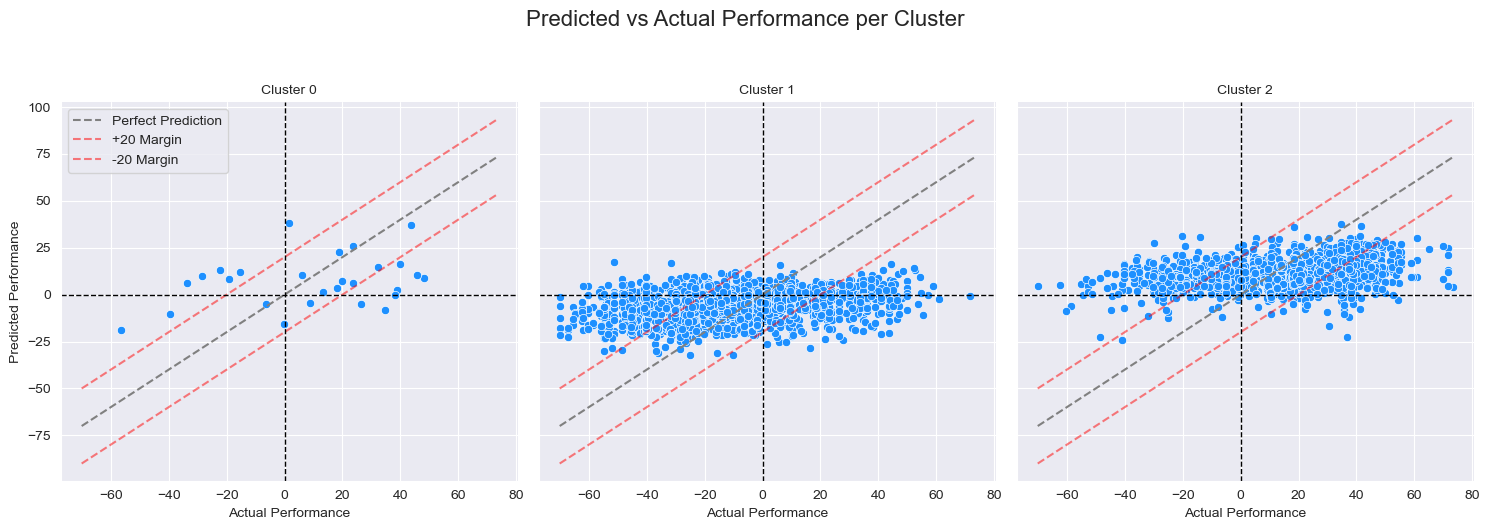

In [33]:
buffer = 20

g = sns.FacetGrid(df2, col="cluster", col_wrap=3, height=5, sharex=True, sharey=True)

g.map_dataframe(sns.scatterplot, x="performance", y="pred_cluster", color='dodgerblue')

min_val = min(df2["performance"].min(), df2["pred_cluster"].min())
max_val = max(df2["performance"].max(), df2["pred_cluster"].max())

for i, ax in enumerate(g.axes.flatten()):
    
    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="gray",
            label="Perfect Prediction" if i == 0 else "")
    
    ax.plot([min_val, max_val], [min_val + buffer, max_val + buffer], ls="--", color="red", alpha=0.5,
            label=f'+{buffer} Margin' if i == 0 else "")
    ax.plot([min_val, max_val], [min_val - buffer, max_val - buffer], ls="--", color="red", alpha=0.5,
            label=f'-{buffer} Margin' if i == 0 else "")
    
    mean_actual = 0
    mean_pred = 0

    ax.axhline(mean_actual, color="black", linestyle="--", linewidth=1)
    ax.axvline(mean_pred, color="black", linestyle="--", linewidth=1)

g.axes[0].legend()

g.set_axis_labels("Actual Performance", "Predicted Performance")
g.set_titles("Cluster {col_name}")
g.fig.suptitle("Predicted vs Actual Performance per Cluster", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In [34]:
conditions_model1 = [
    (df2["pred_cluster"] >= mean_pred) & (df2["performance"] >= mean_actual),  # TP
    (df2["pred_cluster"] < mean_pred) & (df2["performance"] < mean_actual),    # TN
    (df2["pred_cluster"] >= mean_pred) & (df2["performance"] < mean_actual),   # FP
    (df2["pred_cluster"] < mean_pred) & (df2["performance"] >= mean_actual),   # FN
]

choices = ['TP', 'TN', 'FP', 'FN']
df2['quadrant'] = np.select(conditions_model1, choices, default='Other')

counts_model1 =df2['quadrant'].value_counts()

print("Quadrant Classification Counts:")
print(counts_model1)

tp = counts_model1.get('TP', 0)
tn = counts_model1.get('TN', 0)
fp = counts_model1.get('FP', 0)
fn = counts_model1.get('FN', 0)

directional_accuracy_model1 = (tp + tn) / (tp + tn + fp + fn)
print(f"\nDirectional Accuracy: {directional_accuracy_model1:.4f}")

Quadrant Classification Counts:
quadrant
TP    1241
TN    1091
FP     548
FN     460
Name: count, dtype: int64

Directional Accuracy: 0.6982


**Comment:** When examining the predicted vs. actual performance plots by cluster, we can see that the clustering appears to have been effective in grouping students with similar characteristics. Clusters 1 and 2 contain the majority of students, with Cluster 1 tending to include those with lower performance levels, while Cluster 2 generally includes higher-performing students.

Although the model does not perfectly capture the variation in performance within each cluster, evident from the spread around the perfect prediction line, it still demonstrates meaningful signal. In particular, the directional accuracy remains around 70%, indicating that the model is reliably predicting whether a student will perform above or below the average. This is again a promising sign that the model is capturing relevant behavioral patterns, even if the exact predictions aren’t always precise. However, it is slightly lower than our simpler model.

### Model 2 :

Simple Linear Regression where we impute the missing NAN values with the median value for that exam

In [35]:
# print(final_df_med[final_df_med[['performance', 'predicted_performance']].isna().any(axis=1)].isnull().sum())

# final_df_med.dropna(inplace=True)

In [36]:
# final_df_med[final_df_med[['performance', 'predicted_performance']].isna().any(axis=1)]

KeyError: "['predicted_performance'] not in index"

In [37]:
print(res_method2.summary())

final_df_med['predicted_performance'] = res_method2.fittedvalues
rmse_method2 = mean_squared_error(final_df_med["performance"], final_df_med['predicted_performance'])
print('RMSE :', rmse_method2)

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     170.6
Date:                Tue, 29 Apr 2025   Prob (F-statistic):          9.72e-220
Time:                        15:24:50   Log-Likelihood:                -17349.
No. Observations:                3754   AIC:                         3.471e+04
Df Residuals:                    3746   BIC:                         3.476e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

ValueError: Input contains NaN.

**Comment:** The simple linear regression model with imputed NAN's has a R-squared value of 0.242. This is notably lower than both of the previous models. Among the significant predictors, "average_performance_past_exams" remains the most influential, followed by "recent_avg_time_per_activity" and "total_time_spent_on_activity_before_exam", all of which contribute positively to the model's predictive capability.

In [ ]:
final_df_med['predicted_performance'] = res_method2.fittedvalues

plt.figure(figsize=(6, 4))

sns.scatterplot(x='predicted_performance', y='performance', data=final_df_med, color='dodgerblue')

min_val = min(final_df_math_drop['performance'].min(), final_df_math_drop['predicted_performance'].min())
max_val = max(final_df_math_drop['performance'].max(), final_df_math_drop['predicted_performance'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color="gray")

buffer = 20
plt.plot([min_val, max_val], [min_val + buffer, max_val + buffer], ls="--", color="red", alpha=0.5, label=f'+{buffer} Margin')
plt.plot([min_val, max_val], [min_val - buffer, max_val - buffer], ls="--", color="red", alpha=0.5, label=f'-{buffer} Margin')

mean_actual = 0
mean_pred = 0

plt.axhline(mean_actual, color="black", linestyle="--", linewidth=1)
plt.axvline(mean_pred, color="black", linestyle="--", linewidth=1)

plt.xlabel('Actual Performance')
plt.ylabel('Predicted Performance')
plt.title("Predicted vs Actual Performance per Cluster")

plt.show()

In [ ]:

conditions_model2 = [
    (final_df_med["predicted_performance"] >= mean_pred) & (final_df_med["performance"] >= mean_actual),  # TP
    (final_df_med["predicted_performance"] < mean_pred) & (final_df_med["performance"] < mean_actual),    # TN
    (final_df_med["predicted_performance"] >= mean_pred) & (final_df_med["performance"] < mean_actual),   # FP
    (final_df_med["predicted_performance"] < mean_pred) & (final_df_med["performance"] >= mean_actual),   # FN
]

choices = ['TP', 'TN', 'FP', 'FN']
final_df_med['quadrant'] = np.select(conditions_model2, choices, default='Other')


counts_model2 = final_df_med['quadrant'].value_counts()
print("Quadrant Classification Counts:")
print(counts_model2)


tp = counts_model2.get('TP', 0)
tn = counts_model2.get('TN', 0)
fp = counts_model2.get('FP', 0)
fn = counts_model2.get('FN', 0)

directional_accuracy_model2 = (tp + tn) / (tp + tn + fp + fn)
print(f"\nDirectional Accuracy: {directional_accuracy_model2:.4f}")

**Comment:** 

### Model 3 :

Simple Linear Regression where we impute the missing NAN values using KNN

In [ ]:
print(res_method3.summary())

**Comment:** ...

### Model 4 :

Gradient Boosting Regressor that accepts NAN values 

In [ ]:
print("Test R²:", r2_score(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2', n_jobs=-1)
print("5‑fold CV R²: %0.3f ± %0.3f" % (cv_scores.mean(), cv_scores.std()))

**Comment:** ...

### Comparisons between the models 

Here compare the results with maybe a visualisation and some analysis ...

In [ ]:
res_method0.rsquared

*Your discussion/interpretation about your model's behavior goes here*

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

*Your discussion about team responsibilities goes here*

## Annexe

Test without the time dependant activity features

In [ ]:
activity = pd.read_csv('{}/features/activity.csv'.format(DATA_DIR))
performances = pd.read_csv('{}/features/performances.csv'.format(DATA_DIR))

In [ ]:
performances_math = performances[performances['domain']== 'math'].copy()
activity_math = activity[activity['domain']== 'math'].copy()

# Rolling window for recent activity
rolling_window_days = 10

# Convert the 'date' columns to datetime
activity_math['activity_updated'] = pd.to_datetime(activity_math['activity_updated'])
performances_math['time'] = pd.to_datetime(performances_math['time'])

def compute_all_features_for_exam_no_time(exam_row, user_activities, user_exams, window_days=rolling_window_days):

    exam_dt = exam_row['time']

    # Include activities up to and including exam_date
    previous_activities = user_activities[user_activities['activity_updated'] < exam_dt].copy()

    # Rolling window (activities in the last N days, including exam day)
    window_start = exam_dt - pd.Timedelta(days=window_days)
    rolling_activities = previous_activities[previous_activities['activity_updated'] >= window_start].copy()

    features = {}

    # Recent average time per activity (rolling window)
    #total_time_rolling = rolling_activities['time_in_minutes'].sum()
    count_rolling = len(rolling_activities)
    #features['recent_avg_time_per_activity'] = total_time_rolling / count_rolling if count_rolling > 0 else 0

    # Number of days since last activity
    if not previous_activities.empty:
        last_activity_date = previous_activities['activity_updated'].max()
        features['days_since_last_activity'] = (exam_dt - last_activity_date).days
    else:
        features['days_since_last_activity'] = np.nan

    # Total time spent on activities before the exam
    #features['total_time_spent_on_activity_before_exam'] = previous_activities['time_in_minutes'].sum() if not previous_activities.empty else 0

    # Average percentage on past exams
    previous_exams = user_exams[user_exams['time'] < exam_dt]
    features['average_performance_past_exams'] = previous_exams['performance'].mean() if not previous_exams.empty else np.nan

    # Usage Frequency: Average activities per day in rolling window & Active days ratio
    features['avg_activities_per_day_recent'] = count_rolling / window_days if window_days > 0 else np.nan
    if not rolling_activities.empty:
        distinct_days = rolling_activities['activity_updated'].dt.normalize().nunique()
    else:
        distinct_days = 0
    features['active_days_ratio_recent'] = distinct_days / window_days if window_days > 0 else np.nan

    # Activity diversity (rolling window)
    features['diversity_recent'] = rolling_activities['activity_type'].nunique() if not rolling_activities.empty else 0


    return pd.Series(features)

In [ ]:
# Loop over each exam (grouped by user) in performances_math and compute all features.
features_list = []

for user_id, user_exams in performances_math.groupby('user_id'):
    # Get corresponding activities for the user from activity_math and sort by date
    user_activities = activity_math[activity_math['user_id'] == user_id].sort_values('activity_updated')
    user_exams_sorted = user_exams.sort_values('time')

    for exam_index, exam_row in user_exams_sorted.iterrows():
        feats = compute_all_features_for_exam_no_time(exam_row, user_activities, user_exams_sorted, rolling_window_days)
        feats['exam_index'] = exam_index
        features_list.append(feats)

# Output df
features_df = pd.DataFrame(features_list).set_index('exam_index')
performances_math_features = performances_math.join(features_df, how='left')


# scaling the columns
columns_to_scale = [ 'days_since_last_activity','average_performance_past_exams','avg_activities_per_day_recent','active_days_ratio_recent','diversity_recent']


scaler = StandardScaler()
scaled_values = scaler.fit_transform(performances_math_features[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performances_math_features.index)
remaining_df = performances_math_features.drop(columns=columns_to_scale)
final_df = pd.concat([scaled_df, remaining_df], axis=1)

In [ ]:
# Linear Regression Model
mod_annexe = smf.ols(
    formula='performance ~  days_since_last_activity + average_performance_past_exams + avg_activities_per_day_recent + active_days_ratio_recent + diversity_recent',
    data=final_df)

# Fit the model
res_annexe = mod_annexe.fit()

# Print regression results summary
print(res_annexe.summary())